In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [3]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 25 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi

n = 20
m = int(3*n/5)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
positive_edges = [edge for edge in edges if weights[edge]>0]
#weights = {edge:1 for edge in edges}
graph=nx.Graph()
graph.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])


terms = weights
circ_ex = None
BASELINE_SHOTS = 1

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
#         ens = [
#             circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
#             for edge, weight in terms.items()
#         ]
            
#         return sum(ens).real
        samples = list(circ_ex.simulate_counts(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += v
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history

def expectation_objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
        ens = [
            circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
            for edge, weight in terms.items()
        ]
            
        return -sum(ens).real
    return gamma_beta_objective, history



/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/quantum_info/operators/pauli.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zer

<ipython-input-4-3a2e1d7ccf7f>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #


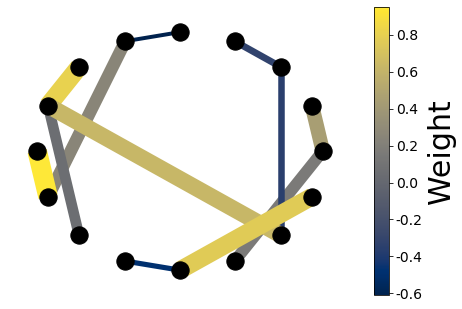

In [4]:
import matplotlib.pyplot as plt
pos=nx.circular_layout(graph)
colors=[int(100+100*weights.get(edge, weights.get((edge[1], edge[0])))) for edge in graph.edges]
widths = [10+10*weights.get(edge, weights.get((edge[1], edge[0]))) for edge in graph.edges]
cmap=plt.cm.cividis
vmin = min(colors)
vmax = max(colors)
nx.draw(graph, pos, node_color='k', edge_color=colors, width=widths, edge_cmap=cmap,
           with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
cb= plt.colorbar(sm)
cb.ax.set_yticklabels([f"{(i-100)/100}" for i in cb.get_ticks()]) #
cb.set_label('Weight', fontsize=30)
#plt.show()
tick_font_size = 14
cb.ax.tick_params(labelsize=tick_font_size)
plt.savefig("/home/ampolloreno/graph.png", dpi=200, bbox_inches='tight')

In [5]:
import networkx as nx
obj, hist = expectation_objective(graph)
all_data = []
bound = np.pi
samples = 20
for g in list(reversed(np.linspace(0, bound, num=samples))):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

3.141592653589793
2.9762456718219092
2.8108986900540254
2.6455517082861415
2.4802047265182576
2.3148577447503738
2.14951076298249
1.984163781214606
1.8188167994467224
1.6534698176788385
1.4881228359109546
1.3227758541430708
1.1574288723751869
0.992081890607303
0.8267349088394192
0.6613879270715354
0.4960409453036515
0.3306939635357677
0.16534698176788384
0.0


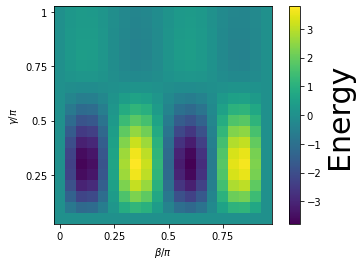

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [.25, .5, .75, 1][::-1])
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)

In [7]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.25*np.pi,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [8]:
from tqdm import tqdm
MAX_ITERATION = 30
shots_per_point = BASELINE_SHOTS
fit_func1, history = objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [9]:
history, result = test_solver(oes)


  3%|▎         | 1/30 [00:00<00:15,  1.88it/s]

(array([-0.57278162,  1.06755445]), 3.4606820768374833, 3.4606820768374833, 0.7853981633974483)


  7%|▋         | 2/30 [00:01<00:14,  1.89it/s]

(array([ 0.49041856, -0.69441267]), 3.963655614613053, 3.963655614613053, 0.7853981633974483)


 10%|█         | 3/30 [00:01<00:14,  1.89it/s]

(array([1.04214006, 0.34730862]), 2.977289539324633, 2.977289539324633, 0.7853981633974483)


 13%|█▎        | 4/30 [00:02<00:13,  1.89it/s]

(array([-0.84346726, -1.11266458]), 3.963655614613053, 3.963655614613053, 0.7853981633974483)


 17%|█▋        | 5/30 [00:02<00:13,  1.89it/s]

(array([-1.16085582, -1.09810374]), 3.8980505264008762, 3.8980505264008762, 0.7853981633974483)


 20%|██        | 6/30 [00:03<00:12,  1.89it/s]

(array([ 0.55261418, -0.92355737]), 3.6495445510015747, 3.6495445510015747, 0.7853981633974483)


 23%|██▎       | 7/30 [00:03<00:12,  1.89it/s]

(array([-0.01856566,  1.05389706]), 2.568609667803276, 2.568609667803276, 0.7853981633974483)


 27%|██▋       | 8/30 [00:04<00:11,  1.90it/s]

(array([ 0.46990611, -0.9156527 ]), 2.5934744948856037, 2.5934744948856037, 0.7853981633974483)


 30%|███       | 9/30 [00:04<00:11,  1.90it/s]

(array([-0.37393049,  0.92934135]), 2.724480485811783, 2.724480485811783, 0.7853981633974483)


 33%|███▎      | 10/30 [00:05<00:10,  1.88it/s]

(array([ 0.3726348, -0.6859274]), 3.005978117366669, 3.005978117366669, 0.7853981633974483)


 37%|███▋      | 11/30 [00:05<00:10,  1.89it/s]

(array([-0.27210444,  1.23413737]), 3.558541682660067, 3.558541682660067, 0.7853981633974483)


 40%|████      | 12/30 [00:06<00:09,  1.89it/s]

(array([-0.28077228,  1.02405892]), 3.645241472888026, 3.645241472888026, 0.7853981633974483)


 43%|████▎     | 13/30 [00:06<00:08,  1.89it/s]

(array([ 0.75504931, -0.94708047]), 3.8113507361729173, 3.8113507361729173, 0.7853981633974483)


 47%|████▋     | 14/30 [00:07<00:08,  1.90it/s]

(array([ 0.59252971, -0.5083032 ]), 3.549431832268093, 3.549431832268093, 0.7853981633974483)


 50%|█████     | 15/30 [00:07<00:07,  1.90it/s]

(array([ 0.13057563, -0.68039478]), 2.92079430150443, 2.92079430150443, 0.7853981633974483)


 53%|█████▎    | 16/30 [00:08<00:07,  1.90it/s]

(array([ 0.69253312, -0.91493145]), 2.4671355202502174, 2.4671355202502174, 0.7853981633974483)


 57%|█████▋    | 17/30 [00:08<00:06,  1.90it/s]

(array([-1.2230171 , -0.62224835]), 3.12929715431906, 3.12929715431906, 0.7853981633974483)


 60%|██████    | 18/30 [00:09<00:06,  1.90it/s]

(array([-0.17767172, -1.43426834]), 2.451311632285496, 2.451311632285496, 0.7853981633974483)


 63%|██████▎   | 19/30 [00:10<00:05,  1.90it/s]

(array([-0.94436482, -0.39030042]), 3.8113507361729173, 3.8113507361729173, 0.7853981633974483)


 67%|██████▋   | 20/30 [00:10<00:05,  1.90it/s]

(array([-1.11180105, -0.36589063]), 3.6150369204802697, 3.6150369204802697, 0.7853981633974483)


 70%|███████   | 21/30 [00:11<00:04,  1.90it/s]

(array([-0.9004202 , -0.27674945]), 3.7457456479607405, 3.7457456479607405, 0.7853981633974483)


 73%|███████▎  | 22/30 [00:11<00:04,  1.90it/s]

(array([-1.2118457 , -1.16509889]), 3.42792838289585, 3.42792838289585, 0.7853981633974483)


 77%|███████▋  | 23/30 [00:12<00:03,  1.90it/s]

(array([1.08463594, 0.60000529]), 4.065675764051487, 4.065675764051487, 0.7853981633974483)


 80%|████████  | 24/30 [00:12<00:03,  1.90it/s]

(array([-0.37382378,  0.48413557]), 3.8113507361729173, 3.8113507361729173, 0.7853981633974483)


 83%|████████▎ | 25/30 [00:13<00:02,  1.90it/s]

(array([-0.43170862,  0.35415528]), 3.005978117366669, 3.005978117366669, 0.7853981633974483)


 87%|████████▋ | 26/30 [00:13<00:02,  1.90it/s]

(array([-1.81813618,  0.52745555]), 2.3686173867670224, 2.3686173867670224, 0.7853981633974483)


 90%|█████████ | 27/30 [00:14<00:01,  1.90it/s]

(array([-1.04648379, -0.47280497]), 3.1736033550172804, 3.1736033550172804, 0.7853981633974483)


 93%|█████████▎| 28/30 [00:14<00:01,  1.90it/s]

(array([1.00851677, 0.64495979]), 3.645241472888026, 3.645241472888026, 0.7853981633974483)


 97%|█████████▋| 29/30 [00:15<00:00,  1.90it/s]

(array([-0.39832001,  0.63860551]), 3.4606820768374833, 3.4606820768374833, 0.7853981633974483)


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]

(array([-0.3734001 ,  1.15999971]), 4.065675764051487, 4.065675764051487, 0.7853981633974483)
local optimum discovered by solver:
 [-0.3734001   1.15999971]
fitness score at this local optimum: 4.065675764051487


([<matplotlib.axis.YTick at 0x7ff1f19338e0>,
 [Text(0, 0.0, '1'),
  Text(0, 5.0, '0.75'),
  Text(0, 10.0, '0.5'),
  Text(0, 15.0, '0.25')])

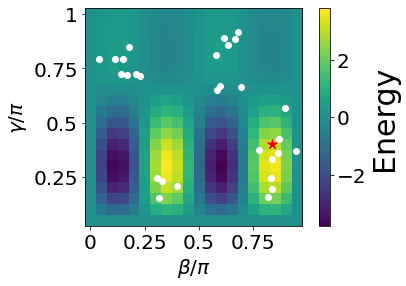

In [34]:
fontsize=20
plt.imshow(all_data)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize)
cb.set_label('Energy', fontsize=30)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [(bound - (el[1]%bound))*(samples-1)/(bound) for el in xys]
plt.scatter(x, y, c='w')
plt.scatter([result[0][0]%(bound)*(samples-1)/(bound)], [(bound - (result[0][1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.ylabel(r"$\gamma/\pi$", fontsize=fontsize)
plt.xlabel(r"$\beta/\pi$", fontsize=fontsize)
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75], fontsize=fontsize)
plt.yticks(plt.yticks()[0][1:-1:2], [.25, .5, .75, 1][::-1], fontsize=fontsize)

# Annealing

In [11]:
shots_per_point = BASELINE_SHOTS
from tqdm import tqdm
annealing_attempts = []
func, history2 = objective(graph)
seed = 1
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result2 = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=NPOPULATION,
    maxfun=one_hour*reprate,
    seed=1)
result2.fun = result2.fun
(result2.x, result2.fun)        

(array([0.99136841, 0.6779282 ]), -4.1312808522636635)

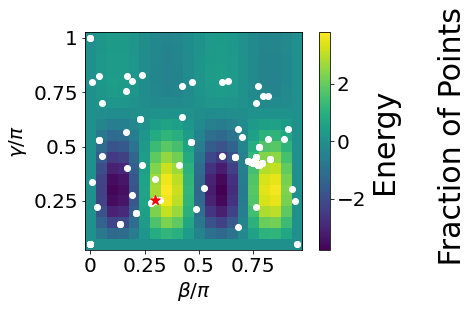

In [40]:
fontsize=20
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2, c='w')
plt.scatter([result2.x[0]%(bound)*(samples-1)/(bound)], [(bound - (result2.x[1]%(bound)))*(samples-1)/(bound)], c='red', marker='*', s=100)
plt.imshow(all_data)
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [.25, .5, .75, 1][::-1])
cb = plt.colorbar()
cb.ax.tick_params(labelsize=fontsize)
plt.ylabel(r"$\gamma/\pi$", fontsize=fontsize)
plt.xlabel(r"$\beta/\pi$", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
cb.set_label('Energy\n\n Fraction of Points', fontsize=30)

Text(0.5, 0, '$\\beta/\\pi$')

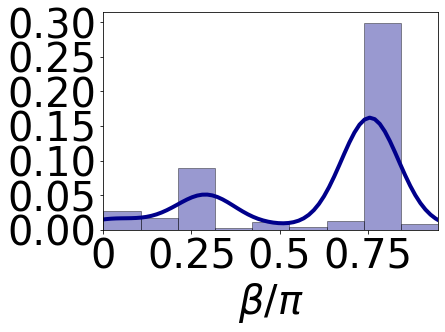

In [43]:
import seaborn as sns
fontsize=40
sns.distplot(x2, hist=True, kde=True, 
             bins=int(180/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim(0, 19)
plt.yticks(fontsize=fontsize)
plt.xticks(plt.xticks()[0][0:-1:2], [0, .25, .5, .75,], fontsize=fontsize)
#plt.yticks(plt.yticks()[0][0:-1:2], plt.yticks()[1][0:-1:2])
plt.xlabel(r"$\beta/\pi$", fontsize=fontsize)
#plt.ylabel("Fraction of Points", fontsize=fontsize)

Text(0.5, 0, '$\\gamma/\\pi$')

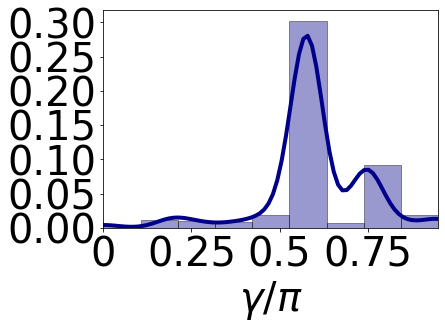

In [44]:
import seaborn as sns
sns.distplot(y2, hist=True, kde=True, 
             bins=int(180/20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim(0, 19)
plt.yticks(fontsize=fontsize)
plt.xticks(plt.xticks()[0][0:-1:2], [0, .25, .5, .75,], fontsize=fontsize)
#plt.yticks(plt.yticks()[0][0:-1:2], plt.yticks()[1][0:-1:2])
plt.xlabel(r"$\gamma/\pi$", fontsize=fontsize)
#plt.ylabel("Fraction of Points", fontsize=fontsize)